# Read Data & Import Libiraies

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install chart_studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
from google.colab import drive

import cv2
import imutils
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from plotly.offline import iplot
from wordcloud import WordCloud

from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, STOPWORDS

import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [ ]:
od.download("https://www.kaggle.com/datasets/landlord/handwriting-recognition/download")

Skipping, found downloaded files in "./handwriting-recognition" (use force=True to force download)


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_csv('/content/handwriting-recognition/written_name_train_v2.csv')
valid = pd.read_csv('/content/handwriting-recognition/written_name_validation_v2.csv')
test = pd.read_csv('/content/handwriting-recognition/written_name_test_v2.csv')
file_path_train = '/content/handwriting-recognition/train_v2/train/'
file_path_test = '/content/handwriting-recognition/test_v2/test/'
file_path_valid = '/content/handwriting-recognition/validation_v2/validation/'

In [ ]:
train.head(5)

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [ ]:
#train10 = pd.read_csv('/content/train_10%.csv')
#train_half = pd.read_csv('/content/train_half.csv')
#train = pd.read_csv('/content/train_clean.csv')
#valid = pd.read_csv('/content/handwriting-recognition/valid_clean.csv')

# Prepare Data
* Data Cleaning
* Get 30 most popular names as our dataset

## Clean Data

### Drop NA

In [ ]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


In [ ]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)
train.shape

(330396, 2)

### Drop Unreadable Data
There are some unreadabe hand written images, drop them as well

In [ ]:
print("Number of UNREADABLE in train set      : ", train['IDENTITY'][train['IDENTITY']=='UNREADABLE'].count())
print("Number of UNREADABLE in validation set : ", valid['IDENTITY'][valid['IDENTITY']=='UNREADABLE'].count())

Number of UNREADABLE in train set      :  102
Number of UNREADABLE in validation set :  12


In [ ]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']
train.shape

(330294, 2)

### Drop Empty Result

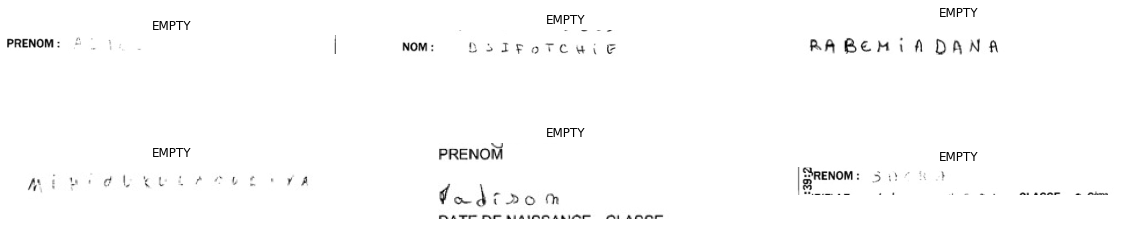

In [ ]:
empty = train[train.IDENTITY == "EMPTY"].copy()
plt.figure(figsize=(20, 15))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = file_path_train+empty.iloc[i].FILENAME
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(empty.iloc[i].IDENTITY, fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [ ]:
print("Number of EMPTY in train set      : ", train['IDENTITY'][train['IDENTITY']=='EMPTY'].count())
print("Number of EMPTY in validation set : ", valid['IDENTITY'][valid['IDENTITY']=='EMPTY'].count())

Number of EMPTY in train set      :  1796
Number of EMPTY in validation set :  187


In [ ]:
train = train[train['IDENTITY'] != 'EMPTY']
valid = valid[valid['IDENTITY'] != 'EMPTY']
train.shape

(328498, 2)

### Change all data to lowercase value
There are lowercase value in the dataset, convert all labels to lowercase to maintain uniformity in lables.

In [ ]:
for i in train['IDENTITY']:
    if i.islower() == True:
        print(i)

yucel
poterlot
zucchi
lemont
borne
guibal
marzo
oliveira
fillat
pascal
hostalery
cribier
tabare


In [ ]:
train['IDENTITY'] = train['IDENTITY'].str.lower()
valid['IDENTITY'] = valid['IDENTITY'].str.lower()

### Reset Index

In [ ]:
print("Size of train set      : ", train.shape)
print("Size of validation set : ", valid.shape)

Size of train set      :  (328498, 2)
Size of validation set :  (41093, 2)


In [ ]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

## Get 30 most popular names

In [ ]:
#train["IDENTITY"].iplot(kind='hist',xTitle='NAME',linecolor='black',opacity=0.8,
                          #color='#FB8072',bargap=0.5,gridcolor='white',title='Distibution of names in training set')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



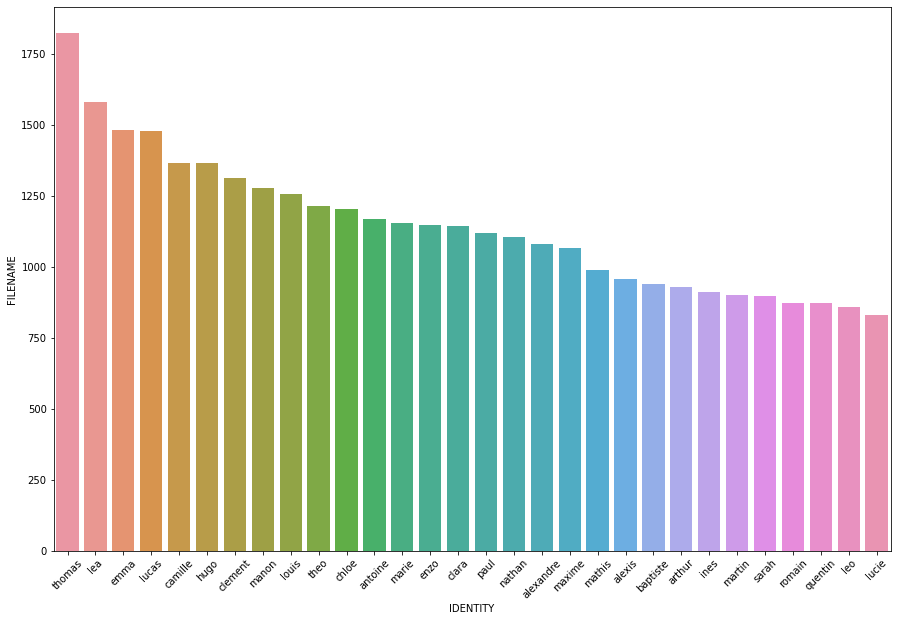

In [ ]:
plt.figure(figsize=(15, 10))
train_count = train.groupby('IDENTITY').agg("count").sort_values(by = ['FILENAME'], ascending = False).reset_index()

sns.barplot(train_count['IDENTITY'][0:30], train_count['FILENAME'][0:30])
plt.xticks(rotation=45)
plt.show()

In [ ]:
train_top30 = train['IDENTITY'].value_counts().head(30)

top30 = []
for i in train_top30.keys():
  top30.append(i)
top30[0:5]

['thomas', 'lea', 'emma', 'lucas', 'hugo']

In [ ]:
train_new = train[train['IDENTITY'].isin(top30)]
valid_new = valid[valid['IDENTITY'].isin(top30)]
test_new = test[test['IDENTITY'].isin(top30)]

print("Size of train set      : ", train_new.shape)
print("Size of validation set : ", valid_new.shape)
print("Size of test set : ", test_new.shape)

Size of train set      :  (34306, 2)
Size of validation set :  (4335, 2)
Size of test set :  (1, 2)


In [ ]:
train_new.reset_index(inplace = True, drop=True) 
valid_new.reset_index(inplace = True, drop=True) 
test_new.reset_index(inplace = True, drop=True) 
#valid.reset_index(inplace = True, drop=True)

In [ ]:
train_new.to_csv('train.csv',index=False)
valid_new.to_csv('valid.csv',index=False)
#valid.to_csv('valid_clean.csv',index=False)

# EDA
* Visualize image & name
* Word Cloud
* Charater Count
* Average Image Exp: Thomas
* Bounding Box

## Visualize image & name

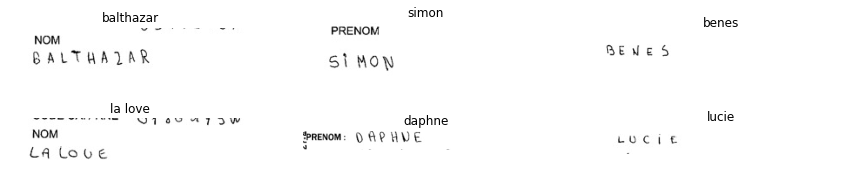

In [ ]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = file_path_train+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

## Word Cloud

In [ ]:
#Creating the text variable
text = " ".join(cat for cat in train_new.IDENTITY)

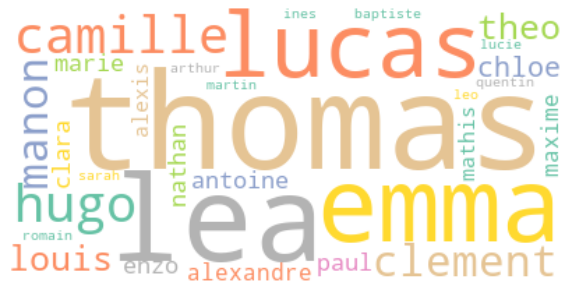

In [ ]:
# Creating word_cloud with text as argument in .generate() method
#skyline_mask = np.array(Image.open("/content/drive/My Drive/Data151221/Skyline.jpeg"))
word_cloud = WordCloud(collocations = False, background_color = 'white', colormap = 'Set2').generate(text)
# Display the generated Word Cloud
plt.rcParams['figure.figsize'] = (10, 10)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Character Count

In [ ]:
text_mash = "".join(cat for cat in train_new.IDENTITY)
res = {i : text_mash.count(i) for i in set(text_mash)}
res

{'a': 27561,
 'b': 938,
 'c': 7335,
 'd': 1080,
 'e': 21538,
 'g': 1367,
 'h': 9531,
 'i': 13285,
 'l': 15556,
 'm': 14798,
 'n': 15071,
 'o': 12191,
 'p': 2056,
 'q': 871,
 'r': 7905,
 's': 9254,
 't': 12193,
 'u': 7849,
 'x': 3105,
 'z': 1148}

In [ ]:
chars = pd.Series(res, name="counts").to_frame()
chars.reset_index(level = 0, inplace = True)
chars.sort_values(by = 'counts', ascending = False, inplace = True)
chars.head(10)

,index,counts
6,a,27561
19,e,21538
2,l,15556
4,n,15071
0,m,14798
14,i,13285
9,t,12193
13,o,12191
16,h,9531
12,s,9254


<BarContainer object of 20 artists>

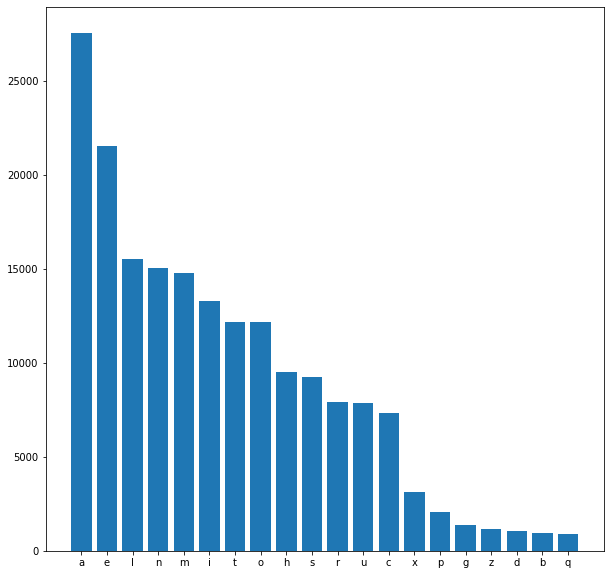

In [ ]:
plt.bar(chars['index'], chars['counts'])